In [1]:
import os
import numpy as np 
# --- provabgs --- 
from provabgs import models as Models

In [2]:
# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

# `DESIspeculator._emulator` test

In [3]:
# load test parameter and spectrum. These were generated for the validation of the trained Speculator model
test_theta = np.load('/Users/chahah/data/gqp_mc/speculator/DESI_complexdust.theta_test.npy')[:10000]
test_logspec = np.load('/Users/chahah/data/gqp_mc/speculator/DESI_complexdust.logspectrum_fsps_test.npy')[:10000]

In [4]:
# initiate desi model 
Mdesi = Models.DESIspeculator()

In [5]:
%timeit Mdesi._emulator(test_theta[0])

1.07 ms ± 83.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [6]:
log_emu = np.array([Mdesi._emulator(tt) for tt in test_theta]) # 100,000 evaluates takes about 2 mins

(0.0, 9.86693299305921e-05)

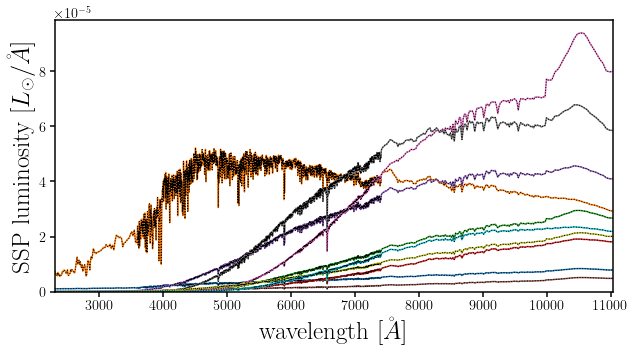

In [7]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
for i in range(10): 
    sub.plot(Mdesi._emu_waves, np.exp(log_emu[i]), c='C%i' % i)
    sub.plot(Mdesi._emu_waves, np.exp(test_logspec[i]), c='k', ls=':', lw=1)
sub.set_xlabel('wavelength [$\AA$]', fontsize=25)
sub.set_xlim(Mdesi._emu_waves.min(), Mdesi._emu_waves.max())
sub.set_ylabel('SSP luminosity [$L_\odot/\AA$]', fontsize=25)
sub.set_ylim(0., None)

(-0.1, 0.1)

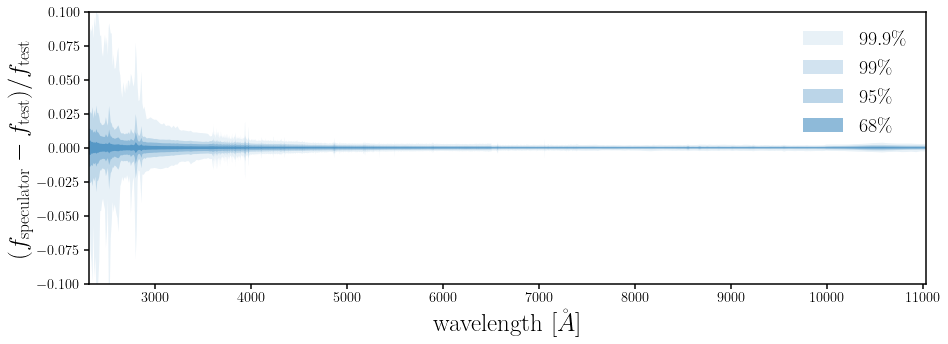

In [8]:
# fractional error of the Speculator model
frac_dspectrum = 1. - np.exp(log_emu - test_logspec)
frac_dspectrum_quantiles = np.nanquantile(frac_dspectrum, 
        [0.0005, 0.005, 0.025, 0.16, 0.84, 0.975, 0.995, 0.9995], axis=0)

fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)
sub.fill_between(Mdesi._emu_waves, 
        frac_dspectrum_quantiles[0],
        frac_dspectrum_quantiles[-1], fc='C0', ec='none', alpha=0.1, label=r'$99.9\%$')
sub.fill_between(Mdesi._emu_waves, 
        frac_dspectrum_quantiles[1],
        frac_dspectrum_quantiles[-2], fc='C0', ec='none', alpha=0.2, label=r'$99\%$')
sub.fill_between(Mdesi._emu_waves, 
        frac_dspectrum_quantiles[2],
        frac_dspectrum_quantiles[-3], fc='C0', ec='none', alpha=0.3, label=r'$95\%$')
sub.fill_between(Mdesi._emu_waves, 
        frac_dspectrum_quantiles[3],
        frac_dspectrum_quantiles[-4], fc='C0', ec='none', alpha=0.5, label=r'$68\%$')
sub.legend(loc='upper right', fontsize=20)
sub.set_xlabel('wavelength [$\AA$]', fontsize=25)
sub.set_xlim(Mdesi._emu_waves.min(), Mdesi._emu_waves.max())
sub.set_ylabel(r'$(f_{\rm speculator} - f_{\rm test})/f_{\rm test}$', fontsize=25)
sub.set_ylim(-0.1, 0.1)

# `DESIspeculator.sed` test

In [9]:
some_theta = np.concatenate([[10.], test_theta[0][:-1]])

(0.0, 1.3147787880822848)

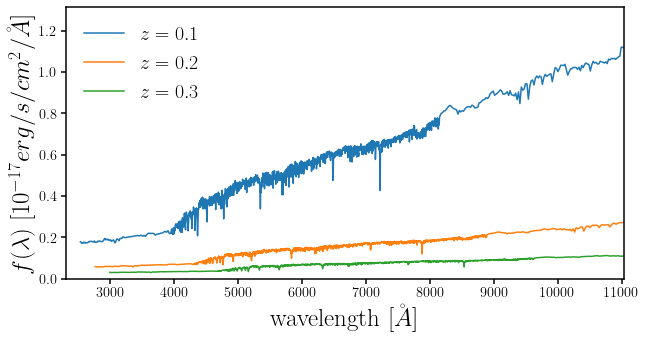

In [10]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
for z in [0.1, 0.2, 0.3]: 
    w, flux = Mdesi.sed(some_theta, z)
    sub.plot(w, flux, label='$z=%.1f$' % z)
sub.legend(loc='upper left', fontsize=20)
sub.set_xlabel('wavelength [$\AA$]', fontsize=25)
sub.set_xlim(Mdesi._emu_waves.min(), Mdesi._emu_waves.max())
sub.set_ylabel(r'$f(\lambda)$ [$10^{-17}erg/s/cm^2/\AA$]', fontsize=25)
sub.set_ylim(0., None)

(0.0, 1.3076797408949192)

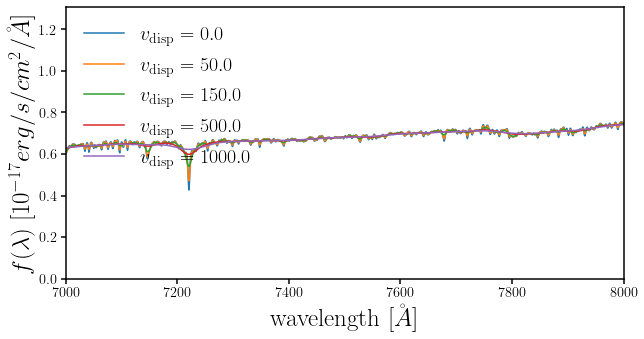

In [11]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
for vdisp in [0., 50, 150, 500, 1000]: 
    w, flux = Mdesi.sed(some_theta, 0.1, vdisp=vdisp)
    sub.plot(w, flux, label=r'$v_{\rm disp}=%.1f$' % vdisp)
sub.legend(loc='upper left', fontsize=20)
sub.set_xlabel('wavelength [$\AA$]', fontsize=25)
sub.set_xlim(7000., 8000.)
sub.set_ylabel(r'$f(\lambda)$ [$10^{-17}erg/s/cm^2/\AA$]', fontsize=25)
sub.set_ylim(0., None)

(0.0, 1.3076797408949192)

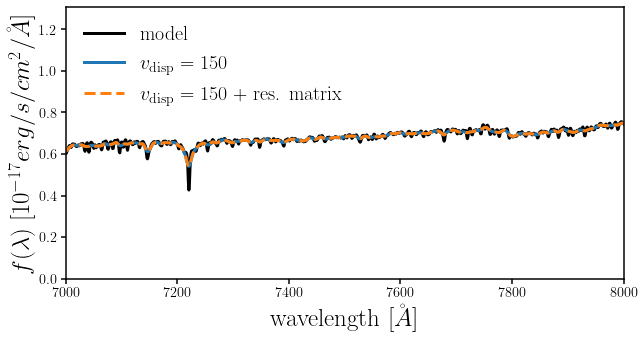

In [12]:
from gqp_mc import data as Data 
specs, prop = Data.Spectra(sim='lgal', noise='bgs0', lib='bc03', sample='mini_mocha') 

fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)

w, flux = Mdesi.sed(some_theta, 0.1, vdisp=0)
sub.plot(w, flux, c='k', lw=3, label=r'model')

w, flux = Mdesi.sed(some_theta, 0.1, vdisp=150)
sub.plot(w, flux, c='C0', lw=3, label=r'$v_{\rm disp}=150$')

w, flux = Mdesi.sed(some_theta, 0.1, vdisp=150, resolution=[specs['res_b'][0], specs['res_r'][0], specs['res_z'][0]])
sub.plot(w, flux, c='C1', lw=3, ls='--', label=r'$v_{\rm disp}=150$ + res. matrix')

sub.legend(loc='upper left', fontsize=20)
sub.set_xlabel('wavelength [$\AA$]', fontsize=25)
sub.set_xlim(7000., 8000.)
sub.set_ylabel(r'$f(\lambda)$ [$10^{-17}erg/s/cm^2/\AA$]', fontsize=25)
sub.set_ylim(0., None)

In [13]:
%timeit w, flux = Mdesi.sed(some_theta, 0.1, vdisp=0)

1.11 ms ± 90.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [14]:
%timeit w, flux = Mdesi.sed(some_theta, 0.1, vdisp=150)

7.18 ms ± 1.47 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
%timeit w, flux = Mdesi.sed(some_theta, 0.1, vdisp=150, resolution=[specs['res_b'][0], specs['res_r'][0], specs['res_z'][0]])

5.92 ms ± 383 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# `DESIspeculator.SFH` and `DESIspeculator.ZH` tests

In [16]:
tage, sfh = Mdesi.SFH(some_theta, 0.1) # get SFH for some arbitrary galaxy at z=0.1
avgSFR = Mdesi.avgSFR(some_theta, 0.1, dt=1)

In [17]:
tlookback = tage[-1] - tage

(0.0, 1396686520.2542415)

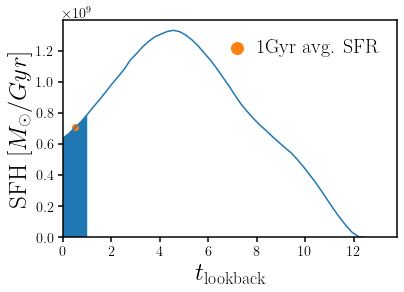

In [18]:
fig = plt.figure(figsize=(6,4))
sub = fig.add_subplot(111)
sub.plot(tlookback, sfh)
i_low = np.argmin(np.abs((tage[-1] - tage) - 1.), axis=0)
sub.fill_between(tlookback[i_low:], np.zeros(len(tage) - i_low), sfh[i_low:])
sub.scatter([tlookback[-1]+0.5], [avgSFR*1e9], label='1Gyr avg. SFR') # convert to per Gyr
sub.legend(loc='upper right', handletextpad=0, markerscale=2, fontsize=20)
sub.set_xlabel(r'$t_{\rm lookback}$', fontsize=25)
sub.set_xlim(0, Mdesi.cosmo.age(0.).value)
sub.set_ylabel('SFH [$M_\odot/Gyr$]', fontsize=25)
sub.set_ylim(0, None)

In [19]:
_, zh = Mdesi.ZH(some_theta, 0.1) # get ZH for some arbitrary galaxy
zmw = Mdesi.Z_MW(some_theta, 0.1)

(0.0, 0.032212956981066444)

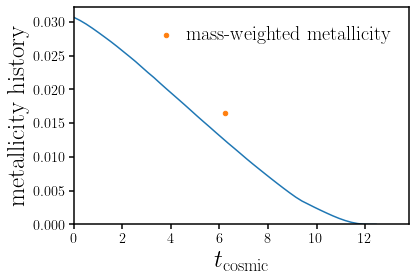

In [20]:
fig = plt.figure(figsize=(6,4))
sub = fig.add_subplot(111)
sub.plot(tlookback, zh)
sub.scatter([np.mean(tlookback)], [zmw], c='C1', s=20, label='mass-weighted metallicity')
sub.legend(loc='upper right', handletextpad=0, fontsize=20)
sub.set_xlabel(r'$t_{\rm cosmic}$', fontsize=25)
sub.set_xlim(0, Mdesi.cosmo.age(0.).value)
sub.set_ylabel('metallicity history', fontsize=25)
sub.set_ylim(0, None)